In [4]:
!pip install catboost
!pip install RDkit

In [1]:
import numpy as np 
import pandas as pd 

from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, Descriptors

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, auc
)
from sklearn.semi_supervised import LabelPropagation

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt


In [20]:
df = pd.read_csv("./HIV.csv")
df

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0


In [21]:
df['smiles_length'] = df['smiles'].str.len()
df

,smiles,activity,HIV_active,smiles_length
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,52
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,84
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,32
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,47
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,22
...,...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0,55
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0,71
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0,60
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0,60


In [4]:
df.describe()

,HIV_active,smiles_length
count,41127.000000,41127.000000
mean,0.035086,45.342451
std,0.184001,22.998528
min,0.000000,4.000000
25%,0.000000,32.000000
50%,0.000000,40.000000
75%,0.000000,53.000000
max,1.000000,580.000000


In [10]:
df_active = df[df['HIV_active'] == 1].copy()
df_active['smiles_length'] = df_active['smiles'].str.len()

In [11]:
df_active

,smiles,activity,HIV_active,smiles_length
11,O=C(O)Cc1ccc(SSc2ccc(CC(=O)O)cc2)cc1,CM,1,36
16,NNP(=S)(NN)c1ccccc1,CM,1,19
80,O=Nc1ccc(O)c(N=O)c1O,CM,1,20
203,Oc1ccc(Cl)cc1C(c1cc(Cl)ccc1O)C(Cl)(Cl)Cl,CM,1,40
234,NNC(=O)c1ccccc1SSc1ccccc1C(=O)NN,CM,1,32
...,...,...,...,...
41090,Cc1cn(COCCCOCC(=O)c2ccccc2)c(=O)[nH]c1=O,CM,1,40
41092,Cc1cn(C2CC3C(COC(CCC[Se]c4ccccc4)N3O)O2)c(=O)[...,CM,1,53
41093,Cc1cn(C2CC3C(COC(CCCC[Se]c4ccccc4)N3O)O2)c(=O)...,CM,1,54
41098,Cc1cn(C2CC3C(COC(CC[Se]C#N)N3O)O2)c(=O)[nH]c1=O,CM,1,47


In [15]:
df_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443 entries, 11 to 41099
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   smiles         1443 non-null   object
 1   activity       1443 non-null   object
 2   HIV_active     1443 non-null   int64 
 3   smiles_length  1443 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 56.4+ KB


In [12]:
df_active.describe()

,HIV_active,smiles_length
count,1443.0,1443.000000
mean,1.0,62.839224
std,0.0,39.899046
min,1.0,11.000000
25%,1.0,37.000000
50%,1.0,50.000000
75%,1.0,81.000000
max,1.0,400.000000


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
custom_color={
    0: "#E94FA7",
    1: "#520697"
}

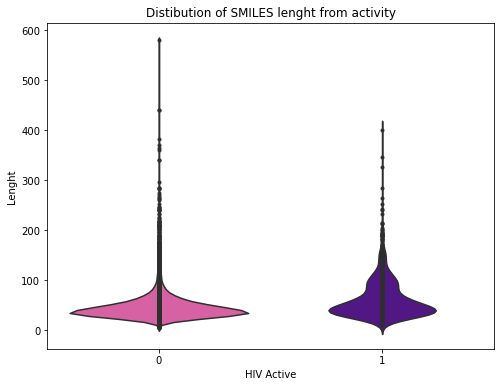

In [33]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x="HIV_active", y="smiles_length", inner="point", palette=custom_color)

plt.xlabel("HIV Active")
plt.ylabel("Lenght")
plt.title("Distibution of SMILES lenght from activity")
plt.savefig("output.png")
plt.show()

In [8]:
df["HIV_active"].value_counts()

HIV_active
0    39684
1     1443
Name: count, dtype: int64

In [9]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
smiles,41127,41127,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
activity,41127,3,CI,39684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HIV_active,41127.0,NaN,NaN,NaN,0.035086,0.184001,0.0,0.0,0.0,0.0,1.0


In [10]:
PandasTools.AddMoleculeColumnToFrame(df,'smiles')

print(df.isnull().sum()) 
print(df.shape)

df.head()

[07:43:08] Explicit valence for atom # 3 Al, 6, is greater than permitted
[07:43:08] Explicit valence for atom # 5 B, 5, is greater than permitted
[07:43:10] Explicit valence for atom # 16 Al, 9, is greater than permitted


smiles        0
activity      0
HIV_active    0
ROMol         7
dtype: int64
(41127, 4)


[07:43:11] Explicit valence for atom # 4 Al, 9, is greater than permitted
[07:43:14] Explicit valence for atom # 12 Al, 7, is greater than permitted
[07:43:14] Explicit valence for atom # 13 Al, 7, is greater than permitted
[07:43:15] WARNING: not removing hydrogen atom without neighbors
[07:43:15] WARNING: not removing hydrogen atom without neighbors
[07:43:15] Explicit valence for atom # 6 Ge, 5, is greater than permitted


,smiles,activity,HIV_active,ROMol
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,<rdkit.Chem.rdchem.Mol object at 0x789115f55850>
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,<rdkit.Chem.rdchem.Mol object at 0x789115f55c40>
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,<rdkit.Chem.rdchem.Mol object at 0x789115f55690>
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,<rdkit.Chem.rdchem.Mol object at 0x789115f55930>
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,<rdkit.Chem.rdchem.Mol object at 0x789115f55700>


<ipython-input-11-a7171de51ca8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HIV_CA['smiles'] = HIV_CA['smiles'].str.slice(stop=50) + '\n' + HIV_CA['smiles'].str.slice(start=50)


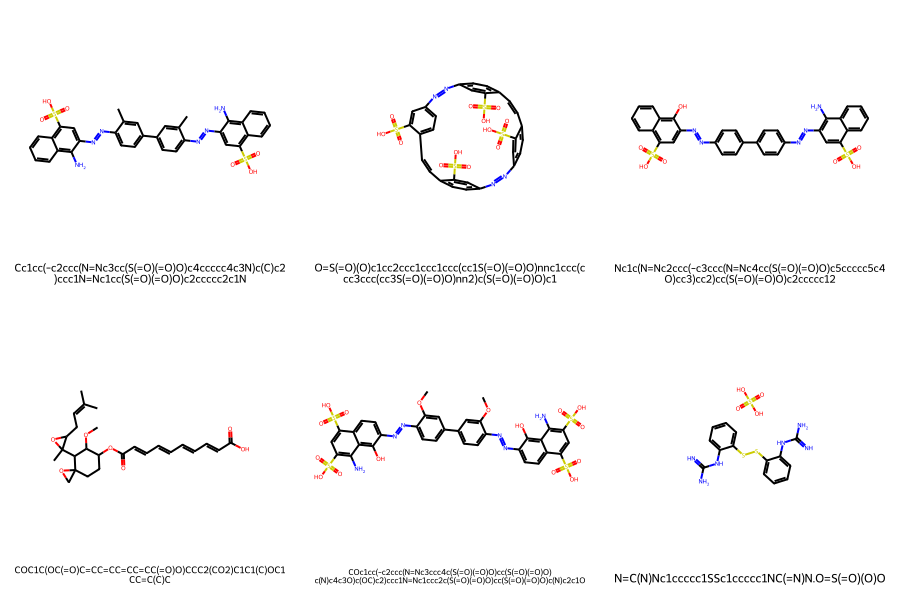

In [11]:
HIV_CA = df[df['activity']=='CA']

HIV_CA['smiles'] = HIV_CA['smiles'].str.slice(stop=50) + '\n' + HIV_CA['smiles'].str.slice(start=50)

HIV_CA_str = PandasTools.FrameToGridImage(HIV_CA[:6], column='ROMol', legendsCol='smiles', 
                                      molsPerRow=3, subImgSize=(300,300))
HIV_CA_str

<ipython-input-12-64dc4a02fc43>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HIV_CI['smiles'] = HIV_CI['smiles'].str.slice(stop=50) + '\n' + HIV_CI['smiles'].str.slice(start=50)


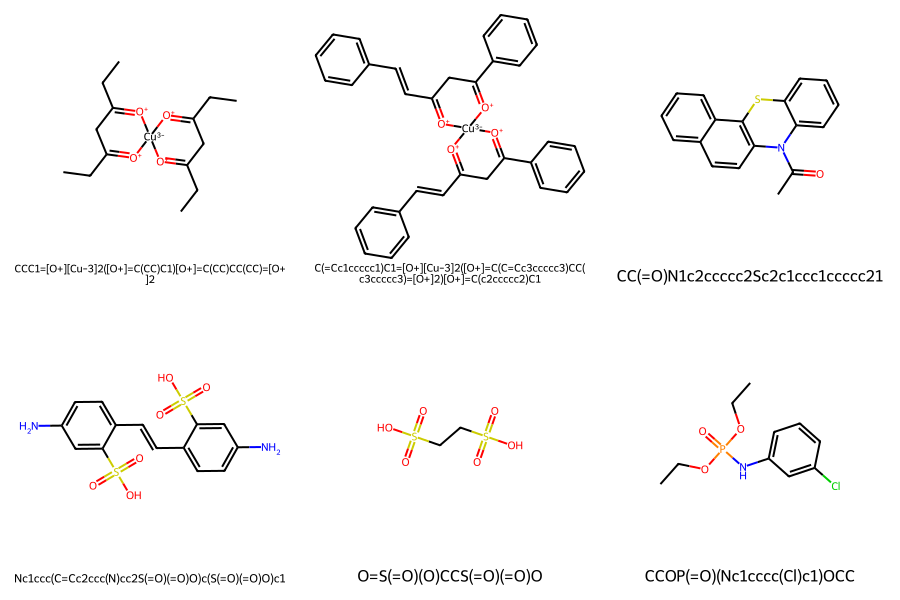

In [12]:
HIV_CI = df[df['activity']=='CI']

HIV_CI['smiles'] = HIV_CI['smiles'].str.slice(stop=50) + '\n' + HIV_CI['smiles'].str.slice(start=50)

HIV_CI_str = PandasTools.FrameToGridImage(HIV_CI[:6], column='ROMol', legendsCol='smiles', 
                                      molsPerRow=3, subImgSize=(300,300))

HIV_CI_str

<ipython-input-13-0cdb211fd46d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HIV_CM['smiles'] = HIV_CM['smiles'].str.slice(stop=50) + '\n' + HIV_CM['smiles'].str.slice(start=50)


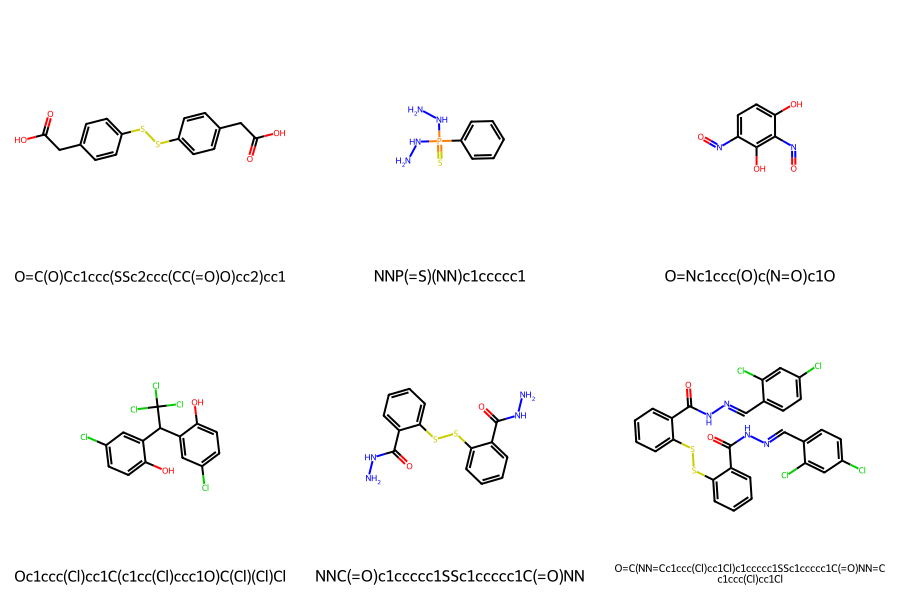

In [13]:
HIV_CM = df[df['activity']=='CM']

HIV_CM['smiles'] = HIV_CM['smiles'].str.slice(stop=50) + '\n' + HIV_CM['smiles'].str.slice(start=50)

HIV_CM_str = PandasTools.FrameToGridImage(HIV_CM[:6], column='ROMol', legendsCol='smiles', 
                                      molsPerRow=3, subImgSize=(300,300))
HIV_CM_str

In [11]:
for i,j in Descriptors.descList:
    df[i] = df['ROMol'].map(j)

print(df.shape)
df.head()

[13:17:57] WARNING: not removing hydrogen atom without neighbors
[13:17:57] WARNING: not removing hydrogen atom without neighbors
[13:19:04] WARNING: not removing hydrogen atom without neighbors
[13:19:04] WARNING: not removing hydrogen atom without neighbors
[13:19:11] WARNING: not removing hydrogen atom without neighbors
[13:19:11] WARNING: not removing hydrogen atom without neighbors
[13:19:12] WARNING: not removing hydrogen atom without neighbors
[13:19:12] WARNING: not removing hydrogen atom without neighbors
[13:19:12] WARNING: not removing hydrogen atom without neighbors
[13:19:12] WARNING: not removing hydrogen atom without neighbors
[13:19:13] WARNING: not removing hydrogen atom without neighbors
[13:19:13] WARNING: not removing hydrogen atom without neighbors
[13:19:13] WARNING: not removing hydrogen atom without neighbors
[13:19:13] WARNING: not removing hydrogen atom without neighbors
[13:19:14] WARNING: not removing hydrogen atom without neighbors
[13:19:14] WARNING: not r

(41127, 212)


<ipython-input-11-b25e7a97ba33>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = df['ROMol'].map(j)


,smiles,activity,HIV_active,ROMol,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,<rdkit.Chem.rdchem.Mol object at 0x7bd9346c92a0>,5.925903,-2.330012,5.925903,0.759994,0.434358,319.888,...,0,0,0,0,0,0,0,0,0,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,<rdkit.Chem.rdchem.Mol object at 0x7bd9346c9b60>,6.515117,-2.879653,6.515117,0.475558,0.104103,564.140,...,0,0,0,0,0,0,0,0,0,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,<rdkit.Chem.rdchem.Mol object at 0x7bd9346c95b0>,12.177015,0.041001,12.177015,0.041001,0.581359,291.375,...,0,0,0,0,0,0,0,0,0,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,<rdkit.Chem.rdchem.Mol object at 0x7bd9346c9310>,11.401803,-4.524487,11.401803,0.087790,0.357615,370.408,...,0,0,0,0,0,0,0,0,0,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,<rdkit.Chem.rdchem.Mol object at 0x7bd9346c97e0>,9.857917,-4.296481,9.857917,0.980324,0.538723,190.198,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df.drop(columns = ["smiles", "activity", "ROMol"], inplace = True)

In [13]:
df

,HIV_active,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,5.925903,-2.330012,5.925903,0.759994,0.434358,319.888,295.696,319.096508,114,...,0,0,0,0,0,0,0,0,0,0
1,0,6.515117,-2.879653,6.515117,0.475558,0.104103,564.140,535.916,563.127808,198,...,0,0,0,0,0,0,0,0,0,0
2,0,12.177015,0.041001,12.177015,0.041001,0.581359,291.375,278.271,291.071785,102,...,0,0,0,0,0,0,0,0,0,0
3,0,11.401803,-4.524487,11.401803,0.087790,0.357615,370.408,356.296,370.029328,128,...,0,0,0,0,0,0,0,0,0,0
4,0,9.857917,-4.296481,9.857917,0.980324,0.538723,190.198,184.150,189.960580,62,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41122,0,13.370142,-0.366239,13.370142,0.007185,0.804191,379.504,350.272,379.225977,148,...,0,0,0,0,0,0,0,0,0,0
41123,0,14.160262,-0.480928,14.160262,0.075082,0.427745,484.596,452.340,484.236208,186,...,0,0,0,0,0,0,0,0,0,0
41124,0,13.962959,-0.415582,13.962959,0.011372,0.450949,440.587,408.331,440.246378,170,...,0,0,0,0,0,0,0,0,0,0
41125,0,13.989331,-0.416314,13.989331,0.009754,0.450949,440.587,408.331,440.246378,170,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df.to_csv("data.csv", index=False)

In [51]:
df = pd.read_csv('/kaggle/input/data-csv/data.csv')

In [52]:
df

,HIV_active,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,5.925903,-2.330012,5.925903,0.759994,0.434358,319.888,295.696,319.096508,114,...,0,0,0,0,0,0,0,0,0,0
1,0,6.515117,-2.879653,6.515117,0.475558,0.104103,564.140,535.916,563.127808,198,...,0,0,0,0,0,0,0,0,0,0
2,0,12.177015,0.041001,12.177015,0.041001,0.581359,291.375,278.271,291.071785,102,...,0,0,0,0,0,0,0,0,0,0
3,0,11.401803,-4.524487,11.401803,0.087790,0.357615,370.408,356.296,370.029328,128,...,0,0,0,0,0,0,0,0,0,0
4,0,9.857917,-4.296481,9.857917,0.980324,0.538723,190.198,184.150,189.960580,62,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41122,0,13.370142,-0.366239,13.370142,0.007185,0.804191,379.504,350.272,379.225977,148,...,0,0,0,0,0,0,0,0,0,0
41123,0,14.160262,-0.480928,14.160262,0.075082,0.427745,484.596,452.340,484.236208,186,...,0,0,0,0,0,0,0,0,0,0
41124,0,13.962959,-0.415582,13.962959,0.011372,0.450949,440.587,408.331,440.246378,170,...,0,0,0,0,0,0,0,0,0,0
41125,0,13.989331,-0.416314,13.989331,0.009754,0.450949,440.587,408.331,440.246378,170,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df.dropna(inplace=True)

In [54]:
X = df.drop(columns=['HIV_active'])
y = df['HIV_active']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29592, 208) (9864, 208) (29592,) (9864,)


In [22]:
from autowoe import AutoWoE, ReportDeco

ModuleNotFoundError: No module named 'autowoe'

In [17]:
auto_woe_0 = AutoWoE(interpreted_model=True,
                     monotonic=False,
                     max_bin_count=5,
                     select_type=None,
                     pearson_th=0.9,
                     metric_th=.505,
                     vif_th=10.,
                     imp_th=0,
                     th_const=32,
                     force_single_split=True,
                     th_nan=0.05,
                     th_cat=0.005,
                     metric_tol=1e-4,
                     cat_alpha=100,
                     cat_merge_to="to_woe_0",
                     nan_merge_to="to_woe_0",
                     imp_type="feature_imp",
                     regularized_refit=False,
                     p_val=0.05,
                     verbose=2
        )

auto_woe_0 = ReportDeco(auto_woe_0, )

auto_woe_0.fit(pd.concat([X_train, y_train], axis=1),
               target_name="HIV_active",
              )

report_params = {"output_path": "test_report", # folder for report generation
                 "report_name": "WHITEBOX REPORT",
                 "report_version_id": 1,
                 "city": "Moscow",
                 "model_aim": "Predict if candidate will work for the company",
                 "model_name": "HR model",
                 "zakazchik": "Kaggle",
                 "high_level_department": "Ai Lab",
                 "ds_name": "Btbpanda",
                 "target_descr": "Candidate will work for the company",
                 "non_target_descr": "Candidate will work for the company"}

auto_woe_0.generate_report(report_params)

[LightGBM] [Info] Number of positive: 807, number of negative: 22223
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26180
[LightGBM] [Info] Number of data points in the train set: 23030, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035041 -> initscore=-3.315559
[LightGBM] [Info] Start training from score -3.315559
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	val_test's auc: 0.834587
dict_keys(['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOG

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


IndexError: list index out of range

In [56]:
columns = ['PEOE_VSA10',
'NumHDonors',        
'BCUT2D_MRHI',        
'SMR_VSA3',           
'BCUT2D_MWHI',        
'MaxPartialCharge',    
'SMR_VSA5',            
'MaxEStateIndex',      
'MinAbsEStateIndex', 
'PEOE_VSA3',           
'BCUT2D_MRLOW',        
'BalabanJ',           
'FpDensityMorgan3',   
'BCUT2D_CHGLO',       
'BCUT2D_LOGPLOW',      
'SMR_VSA4',         
'fr_aryl_methyl',    
'SlogP_VSA4',         
'SlogP_VSA8',       
'PEOE_VSA4',           
'SMR_VSA9',          
'BCUT2D_MWLOW',      
'SlogP_VSA12',       
'VSA_EState6',        
'VSA_EState10',       
'fr_azide',            
'fr_SH'
          ]

In [57]:
X_train = X_train[columns]
X_test = X_test[columns]
X_train

,PEOE_VSA10,NumHDonors,BCUT2D_MRHI,SMR_VSA3,BCUT2D_MWHI,MaxPartialCharge,SMR_VSA5,MaxEStateIndex,MinAbsEStateIndex,PEOE_VSA3,...,SlogP_VSA4,SlogP_VSA8,PEOE_VSA4,SMR_VSA9,BCUT2D_MWLOW,SlogP_VSA12,VSA_EState6,VSA_EState10,fr_azide,fr_SH
2473,5.280014,2,7.550188,0.000000,31.191668,0.349205,32.974962,11.865278,0.345147,0.000000,...,30.342955,0.000000,0.000000,5.749512,10.203237,7.595762,0.893519,0.000000,0,0
29499,5.687386,0,5.947907,4.567100,16.629084,0.344189,0.000000,12.658471,0.272888,0.000000,...,10.114318,27.033152,0.000000,5.687386,10.123673,0.000000,15.145621,0.000000,1,0
5762,0.000000,1,5.759403,5.316789,14.793003,0.010163,18.759549,3.255217,0.505324,0.000000,...,0.000000,12.152040,0.000000,0.000000,9.843024,0.000000,17.591457,0.000000,0,0
38171,17.248535,1,5.980194,4.899910,16.726282,0.362193,5.911046,12.551533,0.092027,0.000000,...,0.000000,6.076020,0.000000,17.248535,10.068390,0.000000,11.865676,0.000000,0,0
23864,17.092779,1,6.394084,0.000000,35.497913,0.267553,19.448525,12.889708,0.196190,0.000000,...,0.000000,22.292943,0.000000,17.073211,10.084357,34.802820,18.105741,18.242782,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6507,0.000000,2,6.078642,9.967957,14.886660,0.073002,25.683286,4.828404,0.963353,9.967957,...,0.000000,43.611700,0.000000,0.000000,10.070949,0.000000,33.595720,0.000000,0,0
11771,0.000000,0,5.712367,0.000000,15.361632,0.090960,81.568923,2.527824,1.018851,0.000000,...,55.389898,0.000000,0.000000,0.000000,9.940459,0.000000,18.794255,0.000000,0,0
39805,5.414990,0,9.089567,0.000000,79.918730,0.320171,19.765380,12.682729,0.119655,0.000000,...,5.414990,0.000000,0.000000,0.000000,9.799506,15.929944,7.405966,3.299876,0,0
918,5.516701,2,6.026221,20.165321,15.210155,0.241618,0.000000,5.440985,0.184311,0.000000,...,0.000000,22.066803,4.983979,0.000000,10.232061,0.000000,7.844991,0.000000,0,0


In [25]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [60]:
# scaler = MinMaxScaler()

# X_train = X_train.fillna(-1)
# X_test = X_test.fillna(-1)
# X_train_s = scaler.fit_transform(X_train)
# X_test_s = scaler.fit_transform(X_test)

In [27]:
from sklearn.metrics import f1_score, confusion_matrix as cm_sklearn

In [38]:
def plot_discrimination_threshold_catboost(clf, X_test, y_test, title='F1', fig_size=(7, 5), dpi=100, save_fig_path=None):
    thresholds = np.linspace(0, 1, 100)
    f1_ls = []
    
    probs = clf.predict_proba(X_test)[:, 1]

    for threshold in thresholds:
        y_predictions = np.where(probs >= threshold, 1, 0)
        f1 = f1_score(y_test, y_predictions, average='binary')
        f1_ls.append(f1)

    metrics = pd.Series(f1_ls, index=thresholds, name='f1')

    plt.rcParams["figure.facecolor"] = 'white'
    plt.rcParams["axes.facecolor"] = 'white'
    plt.rcParams["savefig.facecolor"] = 'white'

    fig, ax = plt.subplots(1, 1, figsize=fig_size, dpi=dpi)
    ax.plot(metrics, label='F1 Score', color='blue')

    best_threshold = metrics.idxmax()
    best_f1 = metrics.max()
    ax.axvline(x=best_threshold, color='black', linestyle='dashed', label=f"$t_r$={best_threshold:.2f}")
    ax.scatter(best_threshold, best_f1, color='red', zorder=5)

    ax.legend(loc='best', frameon=True, framealpha=0.5)
    plt.grid(True)
    plt.xlabel('трешхолд', fontsize=10)
    plt.ylabel('F1', fontsize=10)
    plt.title(title, fontsize=12)

    if save_fig_path:
        plt.savefig(save_fig_path)
    
    plt.show()

    return fig, ax, best_threshold

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [59]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train.dropna(), y_train)
y_pred = rfc.predict(X_test.dropna())

In [60]:
print('Model f1 score : {0:0.4f}'. format(f1_score(y_test, y_pred, average='macro')))

Model f1 score : 0.6525


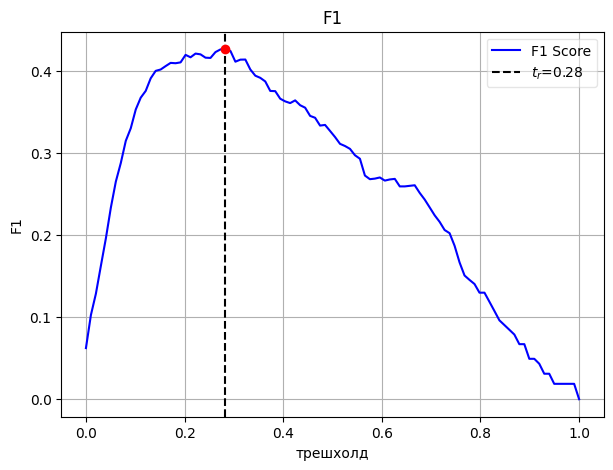

порог: 0.28


In [61]:
fig, ax, best_threshold = plot_discrimination_threshold_catboost(
    clf=rfc, 
    X_test=X_test, 
    y_test=y_test, 
    title="F1"
)

print(f"порог: {best_threshold:.2f}")

In [69]:
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

In [70]:
print('Model f1 score : {0:0.4f}'. format(f1_score(y_test, y_pred, average='macro')))

Model f1 score : 0.5661


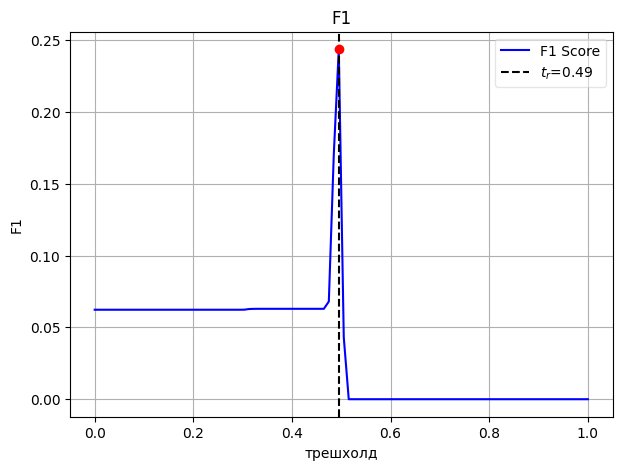

порог: 0.49


In [71]:
fig, ax, best_threshold = plot_discrimination_threshold_catboost(
    clf=ada, 
    X_test=X_test, 
    y_test=y_test, 
    title="F1"
)

print(f"порог: {best_threshold:.2f}")

In [68]:
import lightgbm as lgb

In [74]:
booster = lgb.train(X_train, y_train)
y_pred = booster.predict(X_test)

TypeError: train() only accepts Dataset object, train_set has type 'Series'.

In [39]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

model = CatBoostClassifier(iterations=1000, verbose=0)
model.fit(X_train, y_train)

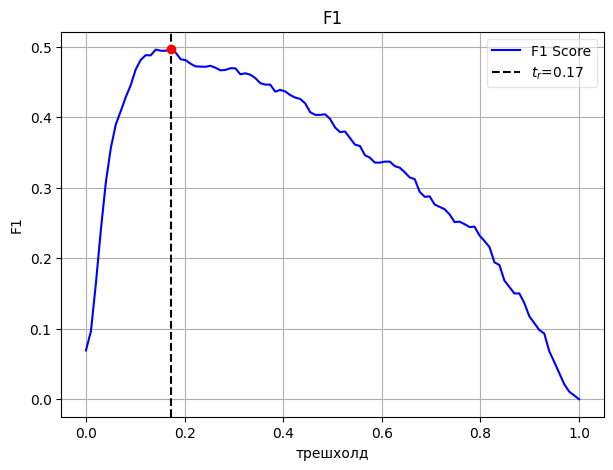

порог: 0.17


In [40]:
fig, ax, best_threshold = plot_discrimination_threshold_catboost(
    clf=model, 
    X_test=X_test, 
    y_test=y_test, 
    title="F1"
)

print(f"порог: {best_threshold:.2f}")

In [41]:
probs = model.predict_proba(X_test)[:, 1]

optimal_predictions = (probs >= best_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, optimal_predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      9914
           1       0.55      0.45      0.50       368

    accuracy                           0.97     10282
   macro avg       0.77      0.72      0.74     10282
weighted avg       0.96      0.97      0.97     10282



In [44]:
import seaborn as sns

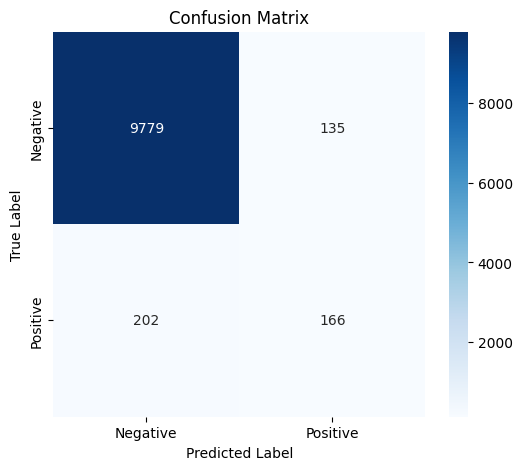

In [45]:
cm = confusion_matrix(y_test, optimal_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [42]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

0:	learn: 0.5472961	total: 11.3ms	remaining: 11.3s
1:	learn: 0.4409347	total: 22.1ms	remaining: 11s
2:	learn: 0.3608478	total: 32.3ms	remaining: 10.7s
3:	learn: 0.3018157	total: 42.4ms	remaining: 10.6s
4:	learn: 0.2613251	total: 51.8ms	remaining: 10.3s
5:	learn: 0.2310054	total: 61.5ms	remaining: 10.2s
6:	learn: 0.2074776	total: 71.6ms	remaining: 10.2s
7:	learn: 0.1886587	total: 81.4ms	remaining: 10.1s
8:	learn: 0.1756262	total: 91.2ms	remaining: 10s
9:	learn: 0.1657386	total: 101ms	remaining: 10s
10:	learn: 0.1580472	total: 112ms	remaining: 10.1s
11:	learn: 0.1515331	total: 122ms	remaining: 10s
12:	learn: 0.1458550	total: 132ms	remaining: 9.99s
13:	learn: 0.1420965	total: 142ms	remaining: 10s
14:	learn: 0.1390127	total: 152ms	remaining: 9.99s
15:	learn: 0.1359006	total: 162ms	remaining: 9.98s
16:	learn: 0.1335848	total: 172ms	remaining: 9.97s
17:	learn: 0.1316886	total: 182ms	remaining: 9.93s
18:	learn: 0.1298317	total: 192ms	remaining: 9.92s
19:	learn: 0.1285401	total: 202ms	remainin

KeyboardInterrupt: 

In [78]:
preds_class = model.predict(X_test)

In [79]:
preds_proba = model.predict_proba(X_test)[:, 1]

In [80]:
cm = confusion_matrix(y_test, preds_class)
f1 = f1_score(y_test, preds_class)

In [81]:
f1

0.4

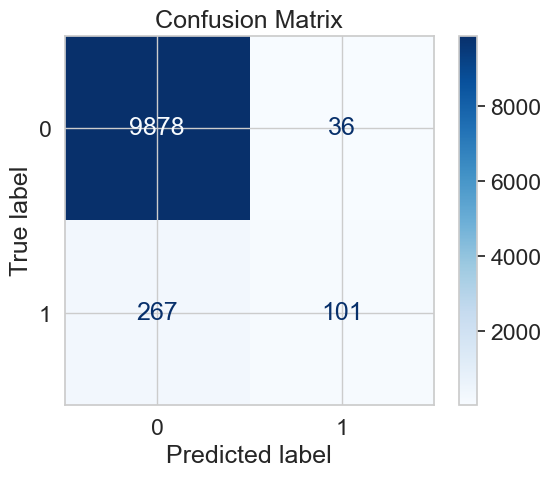

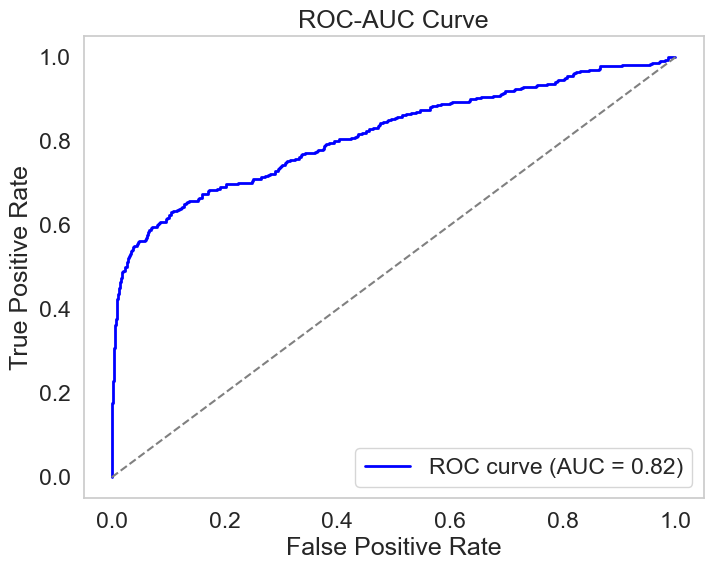

(((30845, 27), (10282, 27), (30845,), (10282,)), 'F1 Score: 0.40', 'AUC: 0.82')

In [82]:
fpr, tpr, _ = roc_curve(y_test, preds_proba)
roc_auc = auc(fpr, tpr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

(X_train.shape, X_test.shape, y_train.shape, y_test.shape), f"F1 Score: {f1:.2f}", f"AUC: {roc_auc:.2f}"